# Exercise 8: Tracking

Some code cells will be marked with 
```
##########################
######## To Do ###########
##########################
```

This indicates that you are being asked to write a piece of code to complete the notebook.

The following two pip installation commands may raise some warnings regarding a `deepcell 0.10.0` dependency conflict. You can ignore the warning and proceed with the rest of the notebook.

In [ ]:
!pip install git+https://github.com/vanvalenlab/deepcell-tf.git@update-tracking-app-models --no-dependencies

In [ ]:
!pip install deepcell-tracking spektral tensorflow-addons pydot

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.segmentation import relabel_sequential
from tensorflow.keras.utils import plot_model

from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

/Users/morganschwartz/opt/anaconda3/envs/mbl/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Problem framing

Given robust segmentation models, cell tracking can be framed simply as a problem of connecting objects between frames. To begin examining this problem, we will start by loading a time lapse movie of fluorescent nuclei.

In [3]:
from deepcell.datasets.tracked import hela_s3_bench

(X_train, y_train), (X_test, y_test) = hela_s3_bench.load_tracked_data(seed=0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (14, 40, 216, 256, 1)
X_test shape: (4, 40, 216, 256, 1)


In [4]:
x = X_train[12]  # chosen batch with divisions

In [35]:
HTML(get_js_video(np.expand_dims(x, axis=0),
                  batch=0, cmap='gray'))

### Initialize nuclear model

The application will download pretrained weights for nuclear segmentation. For more information about application objects, please see our [documentation](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html).

In [5]:
from deepcell.applications import NuclearSegmentation

app = NuclearSegmentation()

2021-09-29 13:35:51.675879: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


For nuclear segmentation, DeepCell uses a PanOptic Net model architecture. A similar implementation of the model can be viewed in the figure below. In this example, the goal is to predict both a whole cell and nuclear segmentation mask from a two channel image labeling the nucleus and membrane of tissue samples. This network begins by utilizing a ResNet50 backbone pretrained on ImageNet. Keras has a set of pretrained backbones available, which we often use interchangeably in DeepCell as a starting point for more complex models. You can learn more about the available backbones [here](https://keras.io/api/applications/). 

From the ResNet50 backbone, we extract several layers for use in a Feature Pyramid Network (FPN). Based on your experience with UNet, what do you think a FPN might be in this network? You can also look at this [blog post](https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c) for an additional introduction to FPNs if you are interested.

Finally, this network branches into 4 semantic heads which each predicts a different feature map (as shown in the figure). Finally we apply a post-processing function to compute the final segmentation masks for whole cells and nuclei.

![PanOpticNet](PanOpticNet.png)

Before we start generating predictions, let's take a minute to look at two visualizations of the model using the Keras functions. The first is `model.summary()` which will display a table listing all of the layers in the model. This view can be very useful for checking the shapes of all of your layers to make sure that all of the math works out correctly.  

In [6]:
app.model.summary()

Model: "panopticnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
location (Location2D)           (None, None, None, 2 0           input_0[0][0]                    
__________________________________________________________________________________________________
concatenate_location (Concatena (None, 512, 512, 3)  0           input_0[0][0]                    
                                                                 location[0][0]                   
__________________________________________________________________________________________________
conv_channels (Conv2D)          (None, 512, 512, 3)  12          concatenate_location[0]

While this model is useful for checking shape information, it doesn't give us a good sense of the connection and structure of the modle. For that information we can use `plot_model`. This visualization is particularly useful because it helps you see the connections between layers. There are enough layers in this model that it will be tricky to get a sense of the complete architecture. However take a minute to explore the graph and see if you can identify the following components: 
- Two semantic heads used to predict the inner distance and outer distance masks
- The Resnet50 backbone imported from Keras
- Connections from the ResNet backbone to feature pyramid layers
- Bonus: How are layers from the ResNet backbone merged with layers in the feature pyramid? How does this compare to how UNet combines layers from one side of the U to the other?

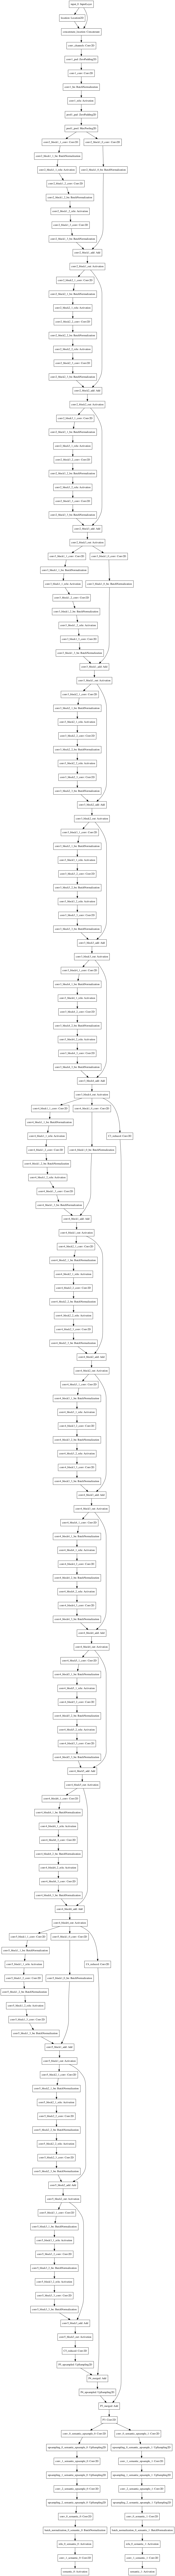

In [8]:
plot_model(app.model)

### Use the application to generate labeled images

Typically, neural networks perform best on test data that is similar to the training data. In the realm of biological imaging, the most common difference between datasets is the resolution of the data measured in microns per pixel. The training resolution of the model can be identified using `app.model_mpp`.

In [6]:
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.65 microns per pixel


The resolution of the input data can be specified in `app.predict` using the `image_mpp` option. The `Application` will rescale the input data to match the training resolution and then rescale to the original size before returning the labeled image.

In [17]:
y = app.predict(x, image_mpp=0.65)

print(y.shape)

(40, 216, 256, 1)


### Save labeled images as a gif to visualize

In [ ]:
HTML(get_js_video(np.expand_dims(y, axis=0),
                  batch=0))

Now we can see that the nuclear model successfully created a label mask for each cell however if you look closely you can see that the label of each cells changes over time. After tracking the cells, we want the label to be consistent over time.

## Linear assignment approach to cell tracking

Now that we have a set of nuclear objects labeled in each frame, cell tracking can be framed simply as a problem of connecting objects in frame $n$ to objects in frame $n+1$. However we need to also deal with the possibility that cells can die or divide into new daughter cells. In order to accomodate this complication, we have adapted a linear assignment framework first introduced by Jaqaman et al (2008). The goal of the linear assignment algorithm is to select a set of pairs such that the sum of the selected weights is minimized. In the framework established by Jaqaman et al, the cost matrix is divided into four quadrants. The top left and bottom right corners correspond to direct matches between objects in frame n to objects in frame $n+1$. The bottom left corner is populated by a diagonal matrix where diagonal values correspond to the probability of a cell dividing. The top right corner is filled with another diagonal matrix in which the diagonal values correspond to the probability of cell death. A diagram of the cost matrix is shown below. 


[Jaqaman et al (2008). Robust single-particle tracking in live-cell time-lapse sequences. Nature methods, 5(8), 695-702.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2747604/)

![Linear Assignment Process](./LAP_Process.jpg)

### Calculate IoU
In order to populate the top left and bottom right corners of the cost matrix, we can begin by using the intersection-over-union of each pair of objects between frame $n$ and frame $n+1$. This metric gives us a measurement of the overlap between objects. First, write a function to calculate the intersection-over-union between two cells.

In [ ]:
##########################
######## To Do ###########
##########################

def calculate_iou(mask1, mask2):
    """Calculates intersection-over-union between two binary masks
    
    Args:
        mask1 (np.array): Binary array for the mask of one cell
        mask2 (np.array): Binary array for the mask of the second cell
        
    Returns:
        float: IoU value
    """
    
    pass

### Prepare IoU Matrix
We can now use the function `calculate_iou` as the basis for a function that takes in two frames and calculates the iou value for each possible pair of cells between the two frames.

In [ ]:
##########################
######## To Do ###########
##########################

def prepare_iou_matrix(frame1, frame2):
    """Prepares a matrix comparing cells in frame 1 to cells in frame2
    based on the iou of the two cells
    
    Args:
        frame1 (np.array): Labeled array for the first frame with n cells
        frame2 (np.array): Labeled array for the second frame with m cells
        
    Returns:
        np.array: nxm array
    """
    # Relabel both arrays sequentially to make calculations easier
    frame1= relabel_sequential(frame1)[0]
    frame2 = relabel_sequential(frame2)[0]
    
    # Add your code here
    # Remember to skip the background (0) when calculating iou
    
    pass

### Inspect IoU matrix
Let's take a look at the iou matrices for 3 frames, two of which have divisions. In the second and third examples you should see that we cannot directly use this matrix to assign cells in the first frame to the second frame because the parent cell in the first frame significantly overlaps with two daughter cells in the second frame.

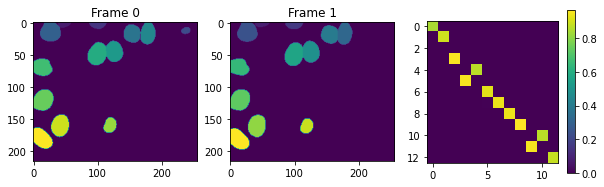

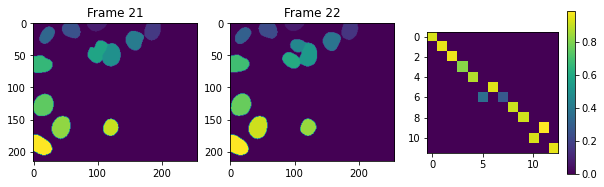

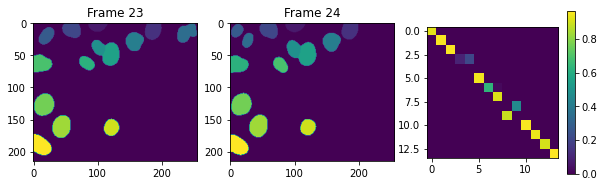

In [20]:
for i in [0, 21, 23]:
    iou = prepare_iou_matrix(y[i], y[i+1])
    fig,ax = plt.subplots(1,3, figsize=(10,10))
    ax[0].imshow(y[i,...,0])
    ax[0].set_title('Frame {}'.format(i))
    ax[1].imshow(y[i+1,...,0])
    ax[1].set_title('Frame {}'.format(i+1))
    cax = ax[2].imshow(iou)
    fig.colorbar(cax, ax=ax[2], shrink=0.3)

### Setup cost matrix
We are now ready to populate the complete cost matrix beginning first with the IoU matrix that we prepared. The linear assignment algorithm is going to minimize the sum of the scores so we will first initialize the cost matrix with an array of ones. The top left and bottom right corners are set to $1 - \texttt{IoU}$. The top right corner is an array of ones with the diagonal set to $1 - P(\texttt{death})$. Finally the bottom left corner is an array of ones with the diagonal set to $1 - P(\texttt{birth})$. We will start with $P(\texttt{death})$ and $P(\texttt{birth})$ equal to 0.5, but these hyperparameters can be tuned to optimize performance.

In [21]:
def make_cost_matrix(frame1, frame2, birth_prob, death_prob):
    iou = prepare_iou_matrix(frame1, frame2)
    
    num1 = iou.shape[0]
    num2 = iou.shape[1]
    nobj = num1 + num2
    
    matrix = np.ones((nobj, nobj))
    
    # 1 - iou to top left and bottom right corners
    cost = 1 - iou
    matrix[:num1, :num2] = cost
    matrix[nobj - num2:, nobj - num1:] = cost.T
    
    # Create diagonal corners with the birth and death rate on diagonals
    birth = (birth_prob * np.eye(num2) + np.ones((num2, num2)) - np.eye(num2))
    death = (death_prob * np.eye(num1) + np.ones((num1, num1)) - np.eye(num1))
    
    # Add diagonal cost columns to bottom left and top right corners
    matrix[nobj - num2:, :num2] = birth
    matrix[:num1, nobj - num1:] = death
    
    return matrix

We'll take a look at the cost matrix for frame 21/22 where there is a division.

In [24]:
t = 21
cost_matrix = make_cost_matrix(y[t], y[t+1], 0.5, 0.5)

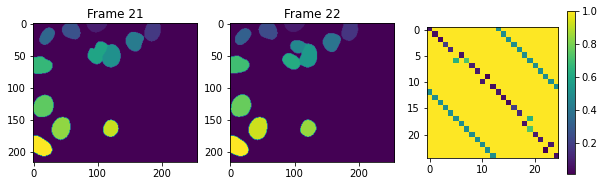

In [25]:
fig,ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(y[t,...,0])
ax[0].set_title('Frame {}'.format(t))
ax[1].imshow(y[t+1,...,0])
ax[1].set_title('Frame {}'.format(t+1))
cax = ax[2].imshow(cost_matrix)
fig.colorbar(cax, ax=ax[2], shrink=0.3)

### Perform linear assignment

In [26]:
from scipy.optimize import linear_sum_assignment

In [27]:
row_ind, col_ind = linear_sum_assignment(cost_matrix)

Let's map these results into an array so that we can visualize the results.

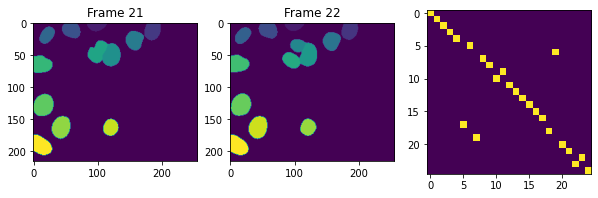

In [29]:
mapping = np.zeros((np.max(row_ind)+1, np.max(col_ind)+1))
for r, c in zip(row_ind, col_ind):
    mapping[r, c] = 1

i = 21
fig,ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(y[i,...,0])
ax[0].set_title('Frame {}'.format(i))
ax[1].imshow(y[i+1,...,0])
ax[1].set_title('Frame {}'.format(i+1))
ax[2].imshow(mapping)

In [30]:
row_ind, col_ind

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 array([ 0,  1,  2,  3,  4,  6, 19,  8,  9, 11, 10, 12, 13, 14, 15, 16, 17,
         5, 18,  7, 20, 21, 23, 22, 24]))

## Deep learning for cell tracking

While the IoU value for each pair of cells is a useful initial probability of two cells being the same between frames, it is ultimately an imperfect metric. Instead we can train a deep learning model to predict the probability of two cells being the same. The model can use information about the cell and its neighborhood in order to produce an accurate prediction. In the `deepcell_tracking` package, we have introduced the `CellTracker` which handles creating the cost matrix, performing linear assignment, and managing the cell lineage data structure to keep track of the trajectory of cells beween frames. 

### Initalize CellTracking application

Create an instance of `deepcell.applications.CellTracking`. You can learn more about how to train this model in [Training and Tracking with GNNs](https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/training/tracking/Training%20and%20Tracking%20with%20GNNs.ipynb)

In [31]:
from deepcell.applications import CellTracking

tracker = CellTracking()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 80217fdd8477f0cb827fe72e8ace6542 so we will re-download the data.
647168/645484 [==============================] - 0s 1us/step


### Track the cells

In [ ]:
tracked_data = tracker.track(np.copy(x), np.copy(y))

### Visualize tracking results

In [ ]:
HTML(get_js_video(np.expand_dims(tracked_data['y_tracked'], axis=0),
                  batch=0))

Now that we've finished using `CellTracker.track_cells`, not only do the annotations preserve label across frames, but the lineage information has been saved in `CellTracker.tracks`.